## 토양 PH 통계 분석

가설: 네 집단의 토양 PH의 분산은 유의미하게 다르다.

In [1]:
# 표준 라이브러리
import sys
from pathlib import Path
from typing import List, Dict
from itertools import combinations

# 서드파티 라이브러리
import pandas as pd
import plotly.express as px
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, shapiro, levene
from statsmodels.stats.multicomp import MultiComparison
import scikit_posthocs as sp

# 로컬 모듈
sys.path.append(str(Path.cwd().parent))
from utils import DATA_DIR, growth_map, energy_map
from utils import eda_missing_data, eda_duplicates, plot_features

In [2]:
import platform
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

mpl.rcParams['axes.unicode_minus'] = False

# 폰트 개인 경로에 맞춰서 변경
# FONT_DIR = Path("/path/to/fonts")
# font_path = FONT_DIR / 'FREESENTATION-6SEMIBOLD.ttf'
# prop = fm.FontProperties(fname=font_path)

In [3]:
def check_normality(data, group_labels, alpha=0.05):
    """
    각 그룹의 정규성 검정 수행
    
    ANOVA의 가정사항 중 정규성을 검증합니다.
    각 그룹별로 Shapiro-Wilk 검정을 수행하여 정규분포 여부를 판단합니다.
    
    Parameters
    ----------
    data : list of arrays
        각 그룹의 데이터를 담은 리스트
    group_labels : list
        각 그룹의 이름
    alpha : float
        유의수준 (기본값: 0.05)
    
    Returns
    -------
    bool
        모든 그룹이 정규성을 만족하는지 여부
        - True: 모든 그룹이 정규분포
        - False: 일부 그룹이 정규분포 아님
    """
    print("\n[정규성 검정 - Shapiro-Wilk Test]")
    print("-"*50)
    
    results = []
    for label, group_data in zip(group_labels, data):
        stat, p_value = shapiro(group_data)
        is_normal = "정규분포 ✓" if p_value > alpha else "정규분포 X"
        results.append({
            '그룹': label,
            'W-통계량': round(stat, 4),
            'p-value': round(p_value, 4),
            '판정': is_normal
        })
        
    result_df = pd.DataFrame(results)
    display(result_df)
    
    all_normal = all(r['p-value'] > alpha for r in results)
    if all_normal:
        print("\n✅ 모든 그룹이 정규성 가정을 만족합니다.")
    else:
        print("\n⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.")
        print("   → 비모수 검정(Kruskal-Wallis) 고려")
    
    return all_normal


def check_homogeneity(data, group_labels, alpha=0.05):
    """
    등분산성 검정 수행
    
    ANOVA의 가정사항 중 등분산성을 검증합니다.
    Levene's test를 사용하여 그룹 간 분산의 동일성을 검정합니다.
    
    Parameters
    ----------
    data : list of arrays
        각 그룹의 데이터를 담은 리스트
    alpha : float
        유의수준 (기본값: 0.05)
    
    Returns
    -------
    bool
        등분산성 만족 여부
        - True: 등분산성 만족
        - False: 등분산성 위반
    """
    print("\n[등분산성 검정 - Levene's Test]")
    print("-"*50)
    
    stat, p_value = levene(*data)
    
    print(f"Levene 통계량: {stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value > alpha:
        print("✅ 등분산성 가정을 만족합니다.")
        equal_var = True
    else:
        print("⚠️ 등분산성 가정을 만족하지 않습니다.")
        print("   → Welch's ANOVA 또는 Games-Howell 사후검정 권장")
        equal_var = False
    
    return equal_var


def calculate_eta_squared(f_statistic, df_between, df_within):
    """
    에타제곱 (효과 크기) 계산
    
    ANOVA 결과의 실질적 중요성을 평가하는 효과 크기를 계산합니다.
    에타제곱은 집단 차이가 전체 변동의 몇 %를 설명하는지 나타냅니다.
    
     주의: 이 함수는 F 통계량을 이용한 근사 공식을 사용합니다.
    정확한 계산을 위해서는 SS(Sum of Squares) 값이 필요하지만,
    F 통계량만으로도 충분히 신뢰할 수 있는 근사치를 제공합니다.
    
    근사 공식: η² ≈ (F × df_between) / (F × df_between + df_within)
    정확한 공식: η² = SS_between / SS_total
    
    Parameters
    ----------
    f_statistic : float
        F 통계량
    df_between : int
        집단 간 자유도
    df_within : int
        집단 내 자유도
    
    Returns
    -------
    tuple
        (에타제곱 값, 해석 문구)
    """
    
    # 근사 공식 사용
    eta_squared = (f_statistic * df_between) / (f_statistic * df_between + df_within)
    
    if eta_squared < 0.01:
        interpretation = "매우 작은 효과"
    elif eta_squared < 0.06:
        interpretation = "작은 효과"
    elif eta_squared < 0.14:
        interpretation = "중간 효과"
    else:
        interpretation = "큰 효과"
    
    return eta_squared, interpretation

def calculate_epsilon_squared(h_statistic, k, n):
    """
    엡실론제곱 (비모수 효과 크기) 계산
    
    Kruskal-Wallis 검정 결과의 실질적 중요성을 평가하는 효과 크기를 계산합니다.
    엡실론제곱은 집단 차이가 전체 순위 변동의 몇 %를 설명하는지 나타냅니다.
    
    Parameters
    ----------
    h_statistic : float
        Kruskal-Wallis H 통계량
    k : int
        집단(그룹) 수
    n : int
        전체 표본 크기
    
    Returns
    -------
    tuple
        (엡실론제곱 값, 해석 문구)
    
    Notes
    -----
    공식: ε² = (H - k + 1) / (n - k)
    - H: Kruskal-Wallis H 통계량
    - k: 그룹 수
    - n: 전체 표본 수
    
    해석 기준 (Cohen's 기준과 동일):
    - < 0.01: 매우 작은 효과
    - 0.01 ~ 0.06: 작은 효과
    - 0.06 ~ 0.14: 중간 효과
    - ≥ 0.14: 큰 효과
    """
    # 엡실론제곱 계산
    epsilon_squared = (h_statistic - k + 1) / (n - k)
    
    
    # 효과 크기 해석
    if epsilon_squared < 0.01:
        interpretation = "매우 작은 효과"
    elif epsilon_squared < 0.06:
        interpretation = "작은 효과"
    elif epsilon_squared < 0.14:
        interpretation = "중간 효과"
    else:
        interpretation = "큰 효과"
    
    return epsilon_squared, interpretation


def perform_tukey_hsd(data, labels):
    """
    Tukey HSD 사후검정 수행
    
    ANOVA에서 유의한 차이가 발견된 경우, 어느 집단 간에 차이가 있는지
    구체적으로 확인하기 위한 다중비교 검정을 수행합니다.
    
    Parameters
    ----------
    data : list of arrays
        각 그룹의 데이터
    labels : list
        각 그룹의 이름
    
    Returns
    -------
    TukeyHSDResults
        Tukey HSD 검정 결과 객체
    """
    print("\n[Tukey HSD 사후검정]")
    print("-"*50)
    
    # 데이터를 긴 형식으로 변환
    all_data = []
    all_labels = []
    
    for label, group_data in zip(labels, data):
        all_data.extend(group_data)
        all_labels.extend([label] * len(group_data))
    
    # Tukey HSD 수행
    mc = MultiComparison(all_data, all_labels)
    result = mc.tukeyhsd()
    
    print(result)
    
    # -----------------------------------------------------------------------------
    # 결과 해석
    # -----------------------------------------------------------------------------
    print("\n[결과 해석]")
    print("-"*50)
    
    # 1. 각 그룹의 평균 계산 및 정렬
    group_means = {}
    for i, label in enumerate(labels):
        group_means[label] = np.mean(data[i])
    
    sorted_groups = sorted(group_means.items(), key=lambda x: x[1], reverse=True)
    
    print("평균 순위:")
    for rank, (group, mean) in enumerate(sorted_groups, 1):
        print(f"  {rank}위: {group} (평균: {mean:.2f})")
    
    # 2. 유의성 관계 파악
    print("\n그룹 간 관계:")
    sig_matrix = {}
    
    # Tukey 결과에서 정보 추출
    for row in result.summary().data[1:]:  # 헤더 제외
        group1 = str(row[0]).strip()
        group2 = str(row[1]).strip()
        meandiff = float(row[2])
        p_adj = float(row[3])
        reject = str(row[6]).strip() == 'True'
        
        # 양방향으로 저장
        sig_matrix[(group1, group2)] = reject
        sig_matrix[(group2, group1)] = reject
        
        # 관계 출력
        if reject:
            print(f"  • {group1} ≠ {group2} (p={p_adj:.4f}, 유의한 차이)")
        else:
            print(f"  • {group1} ≈ {group2} (p={p_adj:.4f}, 차이 없음)")

    
    # 3. 시각화
    fig = result.plot_simultaneous(figsize=(10, 6))
    plt.title('Tukey HSD 95% 신뢰구간')
    plt.xlabel('그룹 간 평균 차이')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return result


def perform_gameshowell(df, dv_col, group_col):
    """
    Games-Howell 사후검정 수행
    
    등분산성 가정을 만족하지 않을 때 사용하는 사후검정입니다.
    정규성은 만족하지만 등분산성이 위반된 경우에 적합합니다.
    
    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임
    dv_col : str
        종속변수(연속형) 컬럼명
    group_col : str
        집단변수(범주형) 컬럼명
    
    Returns
    -------
    pandas.DataFrame
        Games-Howell 검정 결과
    """
    import pingouin as pg
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    print("\n[Games-Howell 사후검정]")
    print("-"*50)
    print("※ 등분산성 가정을 만족하지 않아 Games-Howell 사용\n")
    
    # Games-Howell 수행
    result = pg.pairwise_gameshowell(dv=dv_col, between=group_col, data=df)
    
    # =========================================================================
    # pingouin 버전에 따른 컬럼명 확인 및 처리
    # =========================================================================
    # 최신 버전: 'pval'과 'reject' 대신 'p-unc'와 'sig' 사용
    # 구버전: 'pval'과 'reject' 사용
    
    # p-value 컬럼 확인
    if 'pval' in result.columns:
        pval_col = 'pval'
    elif 'p-unc' in result.columns:
        pval_col = 'p-unc'
    else:
        raise ValueError("p-value 컬럼을 찾을 수 없습니다.")
    
    # reject/sig 컬럼 확인 (없으면 직접 생성)
    if 'reject' not in result.columns and 'sig' not in result.columns:
        result['reject'] = result[pval_col] < 0.05
        reject_col = 'reject'
    elif 'reject' in result.columns:
        reject_col = 'reject'
    else:
        reject_col = 'sig'
        result['reject'] = result[reject_col]  # 호환성을 위해 'reject' 컬럼 추가
    
    # 결과 출력을 위한 컬럼 선택
    display_cols = ['A', 'B', 'mean(A)', 'mean(B)', 'diff', pval_col]
    if reject_col in result.columns:
        display_cols.append(reject_col)
    
    print("[사후검정 결과]")
    print("-"*50)
    try:
        from IPython.display import display
        display(result[display_cols].round(4))
    except ImportError:
        print(result[display_cols].round(4))
    
    # -----------------------------------------------------------------------------
    # 결과 해석
    # -----------------------------------------------------------------------------
    print("\n[결과 해석]")
    print("-"*50)
    
    # 1. 각 그룹의 평균 계산 및 정렬
    group_means = df.groupby(group_col)[dv_col].mean().sort_values(ascending=False)
    
    print("평균 순위:")
    for rank, (group, mean) in enumerate(group_means.items(), 1):
        print(f"  {rank}위: {group} (평균: {mean:.2f})")
    
    # 2. 유의성 관계 파악
    print("\n그룹 간 관계:")
    for _, row in result.iterrows():
        is_significant = row['reject']
        p_value = row[pval_col]
        
        if is_significant:
            print(f"  • {row['A']} ≠ {row['B']} (p={p_value:.4f}, 유의한 차이)")
        else:
            print(f"  • {row['A']} ≈ {row['B']} (p={p_value:.4f}, 차이 없음)")
    
    # 3. 시각화
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 평균 차이와 신뢰구간 시각화
    y_pos = range(len(result))
    comparisons = [f"{row['A']}-{row['B']}" for _, row in result.iterrows()]
    diffs = result['diff'].values
    
    # 신뢰구간 계산 (SE * 1.96)
    errors = result['se'].values * 1.96
    
    colors = ['red' if reject else 'gray' for reject in result['reject']]
    
    ax.barh(y_pos, diffs, xerr=errors, color=colors, alpha=0.6, capsize=5)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(comparisons)
    ax.set_xlabel('평균 차이 (95% CI)')
    ax.set_title('Games-Howell 사후검정 결과')
    ax.grid(True, alpha=0.3, axis='x')
    
    # 범례
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.6, label='유의한 차이 (p<0.05)'),
                      Patch(facecolor='gray', alpha=0.6, label='차이 없음 (p≥0.05)')]
    ax.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()
    
    return result


def perform_dunn_test(df, dv_col, group_col):
    """
    Dunn's 사후검정 수행
    
    Kruskal-Wallis 검정 후 사용하는 비모수 사후검정입니다.
    정규성 가정을 만족하지 않을 때 사용합니다.
    
    Parameters
    ----------
    df : pandas.DataFrame
        분석할 데이터프레임
    dv_col : str
        종속변수(연속형) 컬럼명
    group_col : str
        집단변수(범주형) 컬럼명
    
    Returns
    -------
    pandas.DataFrame
        Dunn's test 검정 결과
    """
    print("\n[Dunn's Test 사후검정]")
    print("-"*50)
    print("※ 정규성 가정을 만족하지 않아 비모수 사후검정 사용\n")
    
    # Dunn's test 수행 (Bonferroni 보정)
    # 반환되는 p-value는 이미 다중비교 보정이 완료된 값
    dunn_result = sp.posthoc_dunn(df, val_col=dv_col, 
                                    group_col=group_col, p_adjust='bonferroni')
    
    print("[사후검정 결과 - p-value 행렬 (Bonferroni 보정 적용됨)]")
    print("-"*50)
    display(dunn_result.round(4))
    
    # -----------------------------------------------------------------------------
    # 결과 해석
    # -----------------------------------------------------------------------------
    print("\n[결과 해석]")
    print("-"*50)
    
    # 1. 각 그룹의 중앙값 계산 및 정렬
    group_medians = df.groupby(group_col)[dv_col].median().sort_values(ascending=False)
    
    print("중앙값 순위 (비모수 검정은 순위 기반이므로 중앙값 참조):")
    for rank, (group, median) in enumerate(group_medians.items(), 1):
        mean = df.groupby(group_col)[dv_col].mean()[group]
        print(f"  {rank}위: {group} (중앙값: {median:.2f}, 참고-평균: {mean:.2f})")
    
    # 2. 유의성 관계 파악
    print("\n그룹 간 관계:")
    groups = dunn_result.columns.tolist()
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            p_val = dunn_result.iloc[i, j]
            sig = "유의한 차이" if p_val < 0.05 else "차이 없음"
            symbol = "≠" if p_val < 0.05 else "≈"
            print(f"  • {groups[i]} {symbol} {groups[j]} (p={p_val:.4f}, {sig})")
    
    # 3. 시각화
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 히트맵으로 p-value 시각화
    import seaborn as sns
    
    # p-value를 색상으로 표현 (낮을수록 진한 색)
    mask = np.triu(np.ones_like(dunn_result, dtype=bool))
    
    sns.heatmap(dunn_result, mask=mask, annot=True, fmt='.4f', 
                cmap='RdYlGn_r', center=0.05, vmin=0, vmax=0.2,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                ax=ax)
    
    ax.set_title('Dunn\'s Test p-value 히트맵\n(낮을수록 유의한 차이, Bonferroni 보정 적용)')
    plt.tight_layout()
    plt.show()
    
    return dunn_result

In [4]:
pandas_kwargs = {
    'memory_map': True,
    'encoding': 'cp949',
    'parse_dates': ['measDate'],
    'date_format': '%Y-%m-%d %H:%M:%S',
    'index_col': 0,
}

env_data: pd.DataFrame = pd.read_csv(DATA_DIR / 'raw' / '22_환경정보.csv', **pandas_kwargs)
env_data

/var/folders/zp/b80h2w41309d2z9qmnh381hw0000gn/T/ipykernel_85852/3589254538.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  env_data: pd.DataFrame = pd.read_csv(DATA_DIR / 'raw' / '22_환경정보.csv', **pandas_kwargs)


,farm_cde,measDate,itemCode,sectCode,classCode,fatrCode,senVal
0,천지인술,2022-09-03 14:42:48,80300,CR,FG,CC24,0.0
1,천지인술,2022-09-03 14:42:48,80300,CR,FG,CC4,0.0
2,천지인술,2022-09-03 14:42:48,80300,CR,FG,CC5,100.0
3,천지인술,2022-09-03 14:42:48,80300,CR,FG,CC6,100.0
4,천지인술,2022-09-03 14:42:48,80300,CR,FG,CC7,100.0
...,...,...,...,...,...,...,...
30867565,토마토명가,2022-12-09 00:00:00,80300,NT,FG,PI,5.6
30867566,토마토명가,2022-12-09 00:00:00,80300,NT,FG,EO,-
30867567,토마토명가,2022-12-09 00:00:00,80300,NT,FG,EI,2.3
30867568,토마토명가,2022-12-09 00:00:00,80300,EL,FG,PL,5.45


In [5]:
filter_data = env_data[env_data['fatrCode'] == 'PL'][['measDate', 'farm_cde', 'senVal']].astype({'senVal': float}).drop_duplicates().reset_index(drop=True)

In [13]:
team_data = filter_data.set_index(['measDate', 'farm_cde'])['senVal'].unstack('farm_cde').dropna()

In [14]:
team_log_data = np.log(team_data)

In [21]:
anova_data = team_data
# anova_data = team_log_data
anova_data

farm_cde,Trigger,이삭줍는 알파고,천지인술,토마토명가
measDate,,,,
2022-09-26,5.68,5.45,5.38,5.03
2022-09-27,5.33,5.50,5.15,5.08
2022-09-28,5.38,5.30,5.10,5.23
2022-09-29,5.35,5.30,5.08,5.23
2022-09-30,6.48,6.40,6.00,6.38
2022-10-01,6.43,6.08,6.45,6.35
2022-10-04,6.23,6.40,6.38,6.70
2022-10-05,6.00,6.38,6.28,6.40
2022-10-06,5.90,6.40,6.45,6.83


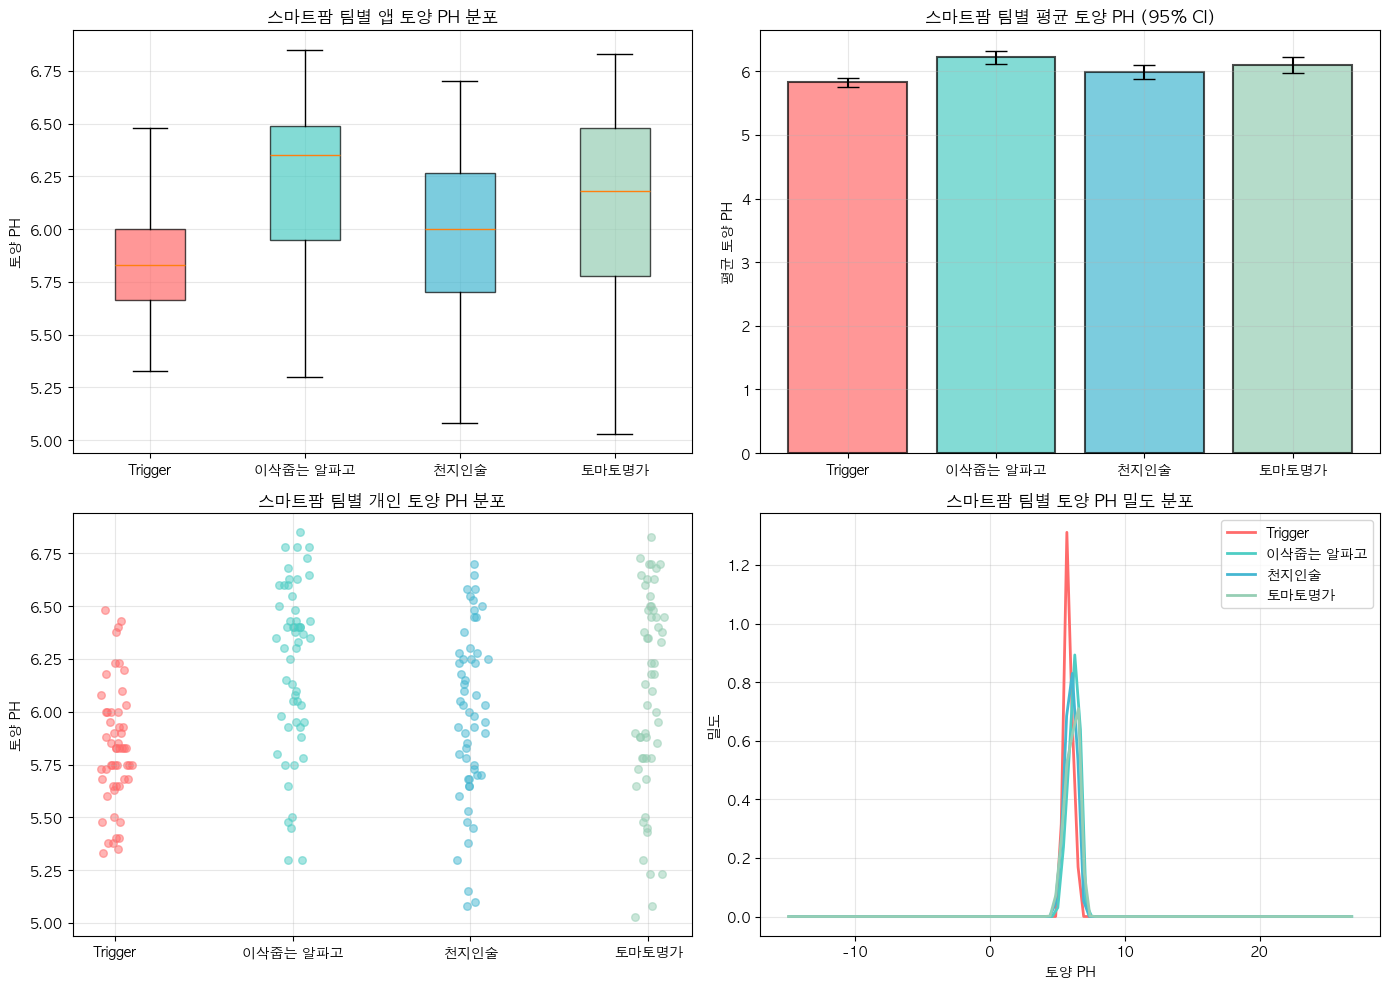

In [29]:
anova_data_lst = [anova_data[col] for col in cols]

# 종합 시각화
fig = plt.figure(figsize=(14, 10))

# 박스플롯
ax1 = plt.subplot(2, 2, 1)
bp = ax1.boxplot(anova_data_lst, tick_labels=cols, patch_artist=True)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_title('스마트팜 팀별 앱 토양 PH 분포')
ax1.set_ylabel('토양 PH')
ax1.grid(True, alpha=0.3)

# 평균 및 오차막대
ax2 = plt.subplot(2, 2, 2)
means = [np.mean(d) for d in anova_data_lst]
sems = [stats.sem(d) for d in anova_data_lst]
x_pos = np.arange(len(cols))

ax2.bar(x_pos, means, yerr=[1.96*s for s in sems], capsize=8,
        color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_title('스마트팜 팀별 평균 토양 PH (95% CI)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(cols)
ax2.set_ylabel('평균 토양 PH')
ax2.grid(True, alpha=0.3)

# 산점도 with jitter
ax3 = plt.subplot(2, 2, 3)
for i, (region, data) in enumerate(zip(cols, anova_data_lst)):
    x = np.random.normal(i, 0.04, size=len(data))
    ax3.scatter(x, data, alpha=0.5, s=30, color=colors[i])
ax3.set_title('스마트팜 팀별 개인 토양 PH 분포')
ax3.set_xticks(range(len(cols)))
ax3.set_xticklabels(cols)
ax3.set_ylabel('토양 PH')
ax3.grid(True, alpha=0.3)

# 밀도 플롯
ax4 = plt.subplot(2, 2, 4)
for region, data, color in zip(cols, anova_data_lst, colors):
    density = stats.gaussian_kde(data)
    x_range = np.linspace(data.min() - 20, data.max() + 20, 100)
    ax4.plot(x_range, density(x_range), label=region, color=color, linewidth=2)
ax4.set_title('스마트팜 팀별 토양 PH 밀도 분포')
ax4.set_xlabel('토양 PH')
ax4.set_ylabel('밀도')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# =============================================================================
# ANOVA 분석 수행
# =============================================================================
print("\n[일원배치 ANOVA]")
print("-"*50)

print("H₀: 4개 스마트팜 팀의 평균 토양 PH가 모두 같다")
print("H₁: 적어도 한 스마트팜 팀의 평균 토양 PH가 다르다")
print("유의수준: α = 0.05")

# -----------------------------------------------------------------------------
# 1. ANOVA 가정 검정
# -----------------------------------------------------------------------------
is_normal = check_normality(anova_data_lst, cols)
is_equal_var = check_homogeneity(anova_data_lst, cols)

# -----------------------------------------------------------------------------
# 2. ANOVA 수행 (정규성 위반 시 Kruskal-Wallis 고려)
# -----------------------------------------------------------------------------
print("\n[ANOVA 검정 결과]")
print("-"*50)

if not is_normal:
    print("⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.")
    print("\n[Kruskal-Wallis 검정 (비모수 검정)]")
    print("\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음")
    print("-"*50)
    h_stat, p_value = stats.kruskal(*anova_data_lst)
    
    # 자유도 및 효과 크기 계산
    k = len(anova_data_lst)
    N = sum(len(group) for group in anova_data_lst)
    df = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f"H-통계량: {h_stat:.4f}")
    print(f"자유도: {df}")
    print(f"p-value: {p_value:.6f}")
    print(f"효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})")
    print(f"   → 스마트팜 팀 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명")
    
    # 결론
    print("\n[검정 결론]")
    if p_value < 0.05:
        print(f"✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각")
        print("   스마트팜 팀별 토양 PH에 유의한 차이가 있음")
    else:
        print(f"❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택")
        print("   스마트팜 팀별 토양 PH에 유의한 차이가 없음")


[일원배치 ANOVA]
--------------------------------------------------
H₀: 4개 스마트팜 팀의 평균 토양 PH가 모두 같다
H₁: 적어도 한 스마트팜 팀의 평균 토양 PH가 다르다
유의수준: α = 0.05

[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,Trigger,0.9680,0.1499,정규분포 ✓
1,이삭줍는 알파고,0.9492,0.0212,정규분포 X
2,천지인술,0.9766,0.3582,정규분포 ✓
3,토마토명가,0.9487,0.0202,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 5.7368
p-value: 0.0009
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[ANOVA 검정 결과]
--------------------------------------------------
⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.

[Kruskal-Wallis 검정 (비모수 검정)]
\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음
--------------------------------------------------
H-통계량: 29.2257
자유도: 3
p-value: 0.000002
효과 크기 (ε²): 0.1214 (중간 효과)
   → 스마트팜 팀 차이가 전체 순위 변동의 12.1% 설명

[검정 결론]
✅ p-value(0.000002) < 0.05 → 귀무가설 기각
   스마트팜 팀별 토양 PH에 유의한 차이가 있음


In [36]:
# 데이터프레임 생성
all_data = []
for team, data in zip(cols, anova_data_lst):
    for value in data:
        all_data.append({'스마트팜 팀': team, '토양 PH': value})

anova_df = pd.DataFrame(all_data)


[Dunn's Test 사후검정]
--------------------------------------------------
※ 정규성 가정을 만족하지 않아 비모수 사후검정 사용

[사후검정 결과 - p-value 행렬 (Bonferroni 보정 적용됨)]
--------------------------------------------------


,Trigger,이삭줍는 알파고,천지인술,토마토명가
Trigger,1.0000,0.0000,0.1295,0.0012
이삭줍는 알파고,0.0000,1.0000,0.0233,0.8460
천지인술,0.1295,0.0233,1.0000,0.9422
토마토명가,0.0012,0.8460,0.9422,1.0000



[결과 해석]
--------------------------------------------------
중앙값 순위 (비모수 검정은 순위 기반이므로 중앙값 참조):
  1위: 이삭줍는 알파고 (중앙값: 6.35, 참고-평균: 6.22)
  2위: 토마토명가 (중앙값: 6.18, 참고-평균: 6.09)
  3위: 천지인술 (중앙값: 6.00, 참고-평균: 5.98)
  4위: Trigger (중앙값: 5.83, 참고-평균: 5.83)

그룹 간 관계:
  • Trigger ≠ 이삭줍는 알파고 (p=0.0000, 유의한 차이)
  • Trigger ≈ 천지인술 (p=0.1295, 차이 없음)
  • Trigger ≠ 토마토명가 (p=0.0012, 유의한 차이)
  • 이삭줍는 알파고 ≠ 천지인술 (p=0.0233, 유의한 차이)
  • 이삭줍는 알파고 ≈ 토마토명가 (p=0.8460, 차이 없음)
  • 천지인술 ≈ 토마토명가 (p=0.9422, 차이 없음)


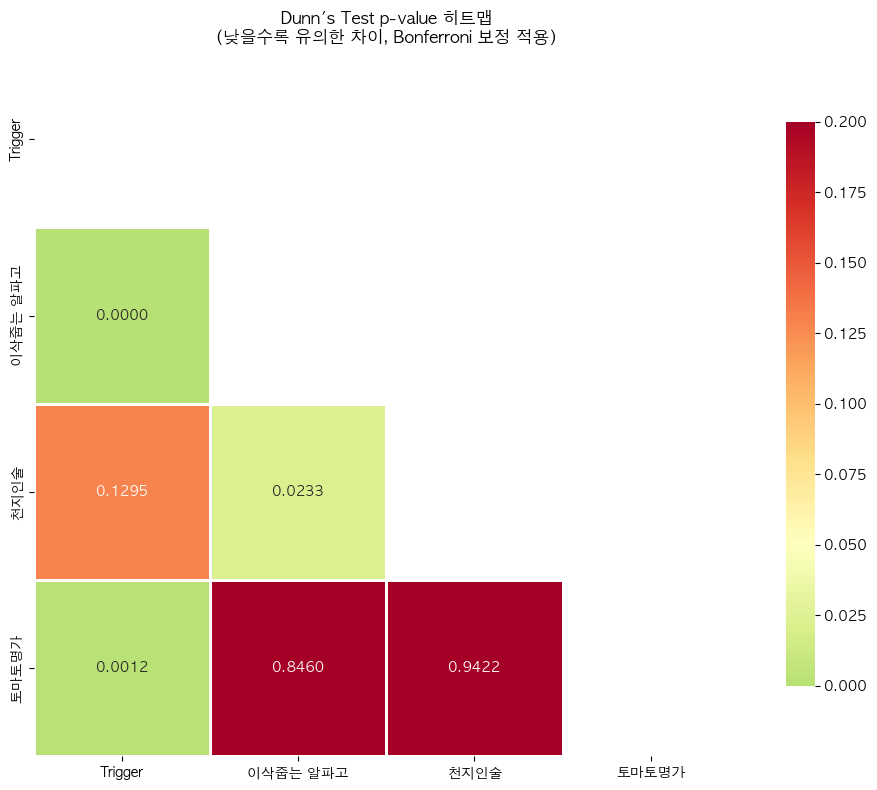

In [37]:
if p_value < 0.05:
    # Kruskal-Wallis 검정 후 사용하는 비모수 사후검정
    dunn_result = perform_dunn_test(anova_df, '토양 PH', '스마트팜 팀')

### 모수검정

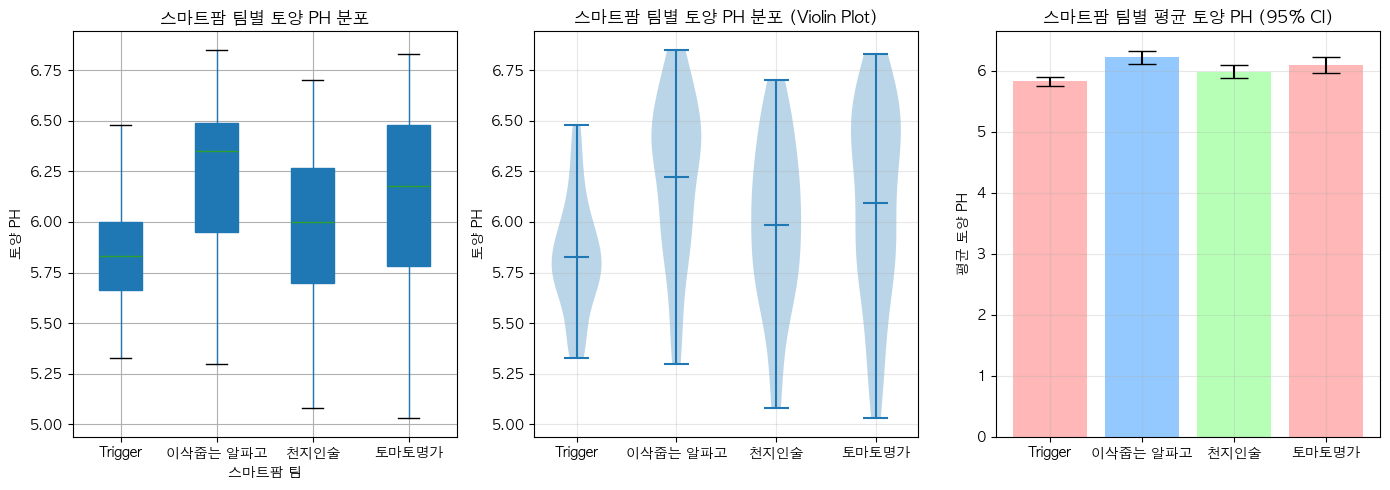

In [22]:
cols = anova_data.columns

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# 박스플롯
anova_data.boxplot(ax=axes[0], grid=True, patch_artist=True)
axes[0].set_title('스마트팜 팀별 토양 PH 분포')
axes[0].set_ylabel('토양 PH')
axes[0].set_xlabel('스마트팜 팀')

# 바이올린 플롯
parts = axes[1].violinplot(
    [anova_data[col] for col in cols],
    positions=list(range(len(cols))), showmeans=True, showextrema=True
)
axes[1].set_title('스마트팜 팀별 토양 PH 분포 (Violin Plot)')
axes[1].set_xticks(list(range(len(cols))))
axes[1].set_xticklabels(cols)
axes[1].set_ylabel('토양 PH')
axes[1].grid(True, alpha=0.3)

# 평균과 95% 신뢰구간
means = [np.mean(anova_data[col]) for col in cols]
sems = [stats.sem(anova_data[col]) for col in cols]
x_pos = np.arange(len(means))

axes[2].bar(x_pos, means, yerr=[1.96*s for s in sems], capsize=10,
            color=['#ff9999', '#66b3ff', '#99ff99'], alpha=0.7)
axes[2].set_title('스마트팜 팀별 평균 토양 PH (95% CI)')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(cols)
axes[2].set_ylabel('평균 토양 PH')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# =============================================================================
# 일원배치 ANOVA 분석
# =============================================================================
# 3개 스마트팜 팀의 토양 PH 평균에 차이가 있는지 검정

print("\n[일원배치 ANOVA]")
print("-"*50)

# 가설 설정
print("H₀: 세 스마트팜 팀의 평균 토양 PH가 모두 같다")
print("    μ₁ = μ₂ = μ₃")
print("H₁: 적어도 한 스마트팜 팀의 평균 토양 PH가 다르다")
print("    적어도 하나의 μᵢ ≠ μⱼ")
print("유의수준: α = 0.05")

# -----------------------------------------------------------------------------
# 1. 기술통계
# -----------------------------------------------------------------------------
print("\n[기술통계]")
stats_data = {
    '배송서비스': cols,
    '표본수': [len(anova_data)] * len(cols),
    '평균': [np.mean(anova_data[col]) for col in cols],
    '표준편차': [np.std(anova_data[col], ddof=1) for col in cols],
    '최소값': [np.min(anova_data[col]) for col in cols],
    '최대값': [np.max(anova_data[col]) for col in cols]
}
stats_df = pd.DataFrame(stats_data)
display(stats_df.round(2))

# -----------------------------------------------------------------------------
# 2. ANOVA 가정 검정
# -----------------------------------------------------------------------------
data_groups = [anova_data[col] for col in cols]
group_labels = cols

# 정규성 검정
is_normal = check_normality(data_groups, group_labels)

# 등분산성 검정  
is_equal_var = check_homogeneity(data_groups, group_labels)

# -----------------------------------------------------------------------------
# 3. ANOVA 수행
# -----------------------------------------------------------------------------
print("\n[ANOVA 검정 결과]")
print("-"*50)

# F 검정 수행
# F = MSB(집단 간 평균제곱) / MSW(집단 내 평균제곱)
f_stat, p_value = f_oneway(*[anova_data[col] for col in cols])

# 자유도 계산
k = 3  # 그룹 수
N = len(anova_data) * len(cols)  # 전체 표본 수
df_between = k - 1  # 집단 간 자유도
df_within = N - k   # 집단 내 자유도

print(f"F-통계량: {f_stat:.4f}")
print(f"자유도: F({df_between}, {df_within})")
print(f"p-value: {p_value:.6f}")

# -----------------------------------------------------------------------------
# 4. 효과 크기 계산
# -----------------------------------------------------------------------------
eta_sq, interpretation = calculate_eta_squared(f_stat, df_between, df_within)
print(f"효과 크기 (η²): {eta_sq:.4f} ({interpretation})")
print(f"   → 스마트팜 팀 차이가 전체 변동의 {eta_sq*100:.1f}% 설명")

# -----------------------------------------------------------------------------
# 5. 통계적 결론
# -----------------------------------------------------------------------------
print("\n[결론]")
if p_value < 0.05:
    print(f"✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각")
    print("   스마트팜 팀별 토양 PH에 유의한 차이가 있음")
    print("   → 사후검정으로 구체적인 차이 확인 필요")
else:
    print(f"❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택")
    print("   스마트팜 팀별 토양 PH에 유의한 차이가 없음")


[일원배치 ANOVA]
--------------------------------------------------
H₀: 세 스마트팜 팀의 평균 토양 PH가 모두 같다
    μ₁ = μ₂ = μ₃
H₁: 적어도 한 스마트팜 팀의 평균 토양 PH가 다르다
    적어도 하나의 μᵢ ≠ μⱼ
유의수준: α = 0.05

[기술통계]


,배송서비스,표본수,평균,표준편차,최소값,최대값
0,Trigger,55,5.83,0.28,5.33,6.48
1,이삭줍는 알파고,55,6.22,0.40,5.30,6.85
2,천지인술,55,5.98,0.41,5.08,6.70
3,토마토명가,55,6.09,0.48,5.03,6.83



[정규성 검정 - Shapiro-Wilk Test]
--------------------------------------------------


,그룹,W-통계량,p-value,판정
0,Trigger,0.9680,0.1499,정규분포 ✓
1,이삭줍는 알파고,0.9492,0.0212,정규분포 X
2,천지인술,0.9766,0.3582,정규분포 ✓
3,토마토명가,0.9487,0.0202,정규분포 X



⚠️ 일부 그룹이 정규성 가정을 만족하지 않습니다.
   → 비모수 검정(Kruskal-Wallis) 고려

[등분산성 검정 - Levene's Test]
--------------------------------------------------
Levene 통계량: 5.7368
p-value: 0.0009
⚠️ 등분산성 가정을 만족하지 않습니다.
   → Welch's ANOVA 또는 Games-Howell 사후검정 권장

[ANOVA 검정 결과]
--------------------------------------------------
F-통계량: 9.6611
자유도: F(2, 217)
p-value: 0.000005
효과 크기 (η²): 0.0818 (중간 효과)
   → 스마트팜 팀 차이가 전체 변동의 8.2% 설명

[결론]
✅ p-value(0.000005) < 0.05 → 귀무가설 기각
   스마트팜 팀별 토양 PH에 유의한 차이가 있음
   → 사후검정으로 구체적인 차이 확인 필요


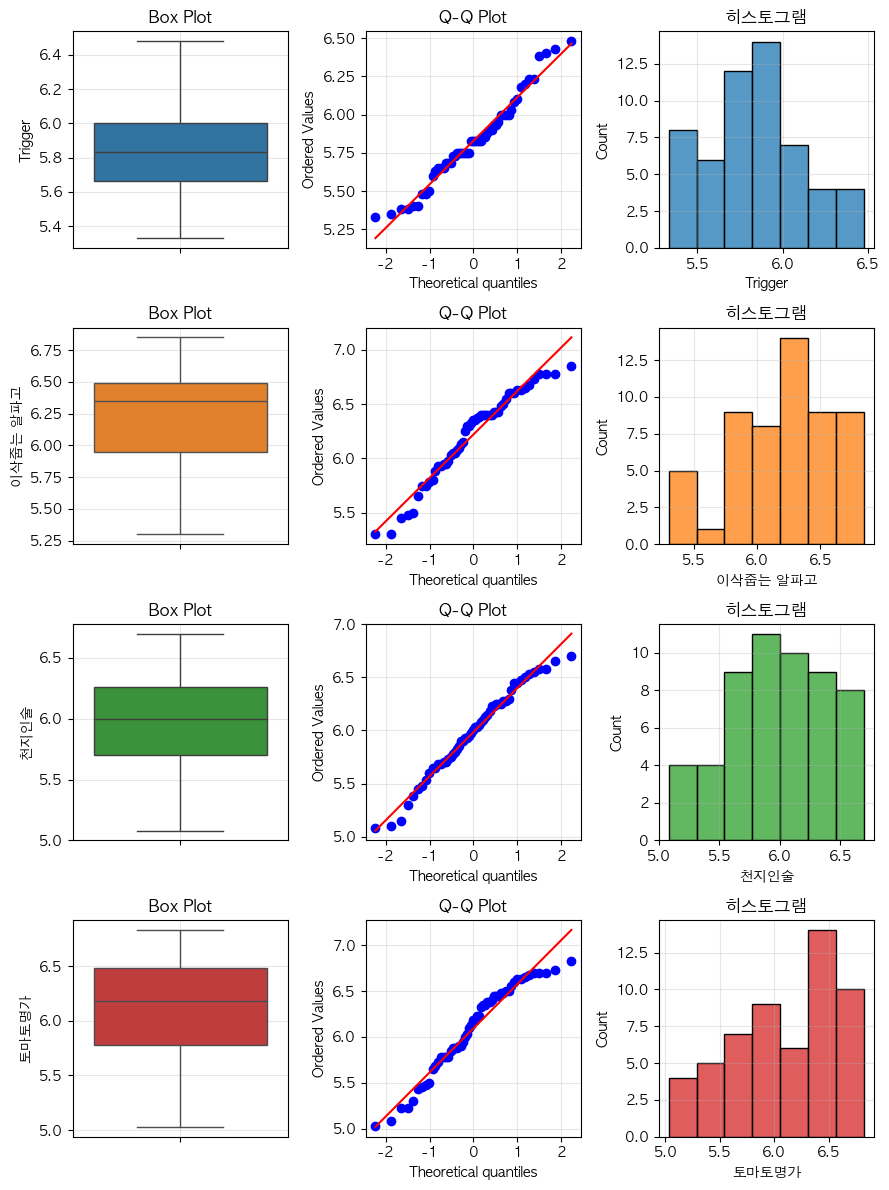

In [24]:
colors = [
    "#1f77b4",  # measDate
    "#ff7f0e",  # farm_cde
    "#2ca02c",  # water_usage
    "#d62728",  # water_cost
    # "#9467bd",  # fertilizer_usage
    # "#8c564b",  # fertilizer_cost
    # "#e377c2",  # heating_energy_usage
    # "#7f7f7f",  # heating_energy_cost
    # "#bcbd22",  # CO2_usage
    # "#17becf",  # CO2_cost
    # "#aec7e8",  # mist_usage_time
    # "#ffbb78"   # mist_cost
]
plot_features(anova_data, cols, colors)


사후검정: Tukey HSD

[Tukey HSD 사후검정]
--------------------------------------------------
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
 Trigger 이삭줍는 알파고   0.3925    0.0  0.1964  0.5887   True
 Trigger     천지인술   0.1562 0.1693   -0.04  0.3524  False
 Trigger    토마토명가   0.2653 0.0031  0.0691  0.4615   True
이삭줍는 알파고     천지인술  -0.2364  0.011 -0.4326 -0.0402   True
이삭줍는 알파고    토마토명가  -0.1273 0.3369 -0.3235  0.0689  False
    천지인술    토마토명가   0.1091  0.476 -0.0871  0.3053  False
--------------------------------------------------------

[결과 해석]
--------------------------------------------------
평균 순위:
  1위: 이삭줍는 알파고 (평균: 6.22)
  2위: 토마토명가 (평균: 6.09)
  3위: 천지인술 (평균: 5.98)
  4위: Trigger (평균: 5.83)

그룹 간 관계:
  • Trigger ≠ 이삭줍는 알파고 (p=0.0000, 유의한 차이)
  • Trigger ≈ 천지인술 (p=0.1693, 차이 없음)
  • Trigger ≠ 토마토명가 (p=0.0031, 유의한 차이)
  • 이삭줍는 알파고 ≠ 천지인술 (p=0.0110, 유의한 차이)
  • 이삭줍는 알파고 ≈

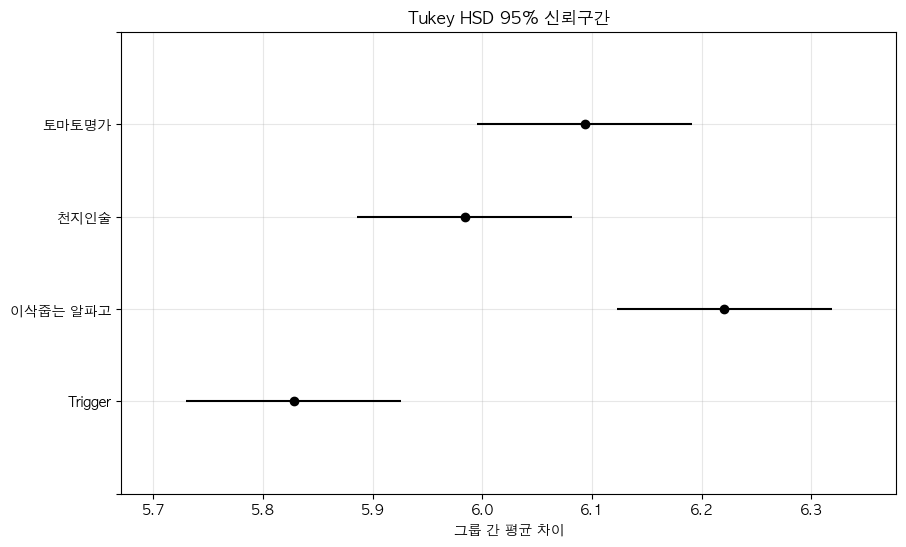


[비즈니스 인사이트]
--------------------------------------------------
• 모든 스마트팜 팀 간 토양 PH 차이가 통계적으로 유의함


In [25]:
# =============================================================================
# 사후검정 (Post-hoc Test)
# =============================================================================
# ANOVA가 유의한 경우에만 수행
# 어느 스마트팜 팀 간에 구체적으로 차이가 있는지 확인

if p_value < 0.05:
    print("\n" + "="*60)
    print("사후검정: Tukey HSD")
    print("="*60)
    
    tukey_result = perform_tukey_hsd(data_groups, group_labels) #정규성과, 등분산성을 모두 만족하는 경우 해당 함수 활용
    
    
    # -----------------------------------------------------------------------------
    # 비즈니스 인사이트 도출
    # -----------------------------------------------------------------------------
    print("\n[비즈니스 인사이트]")
    print("-"*50)
    print("• 모든 스마트팜 팀 간 토양 PH 차이가 통계적으로 유의함")